# Groover - Lazy employee

In [2]:
import numpy as np
from qiskit import QuantumCircuit, transpile
from qiskit.quantum_info import Operator, Statevector
from qiskit.visualization import array_to_latex, plot_distribution
from qiskit.circuit.library import ZGate
from qiskit_aer import Aer

In [3]:
def oracle(n, ignore_qb):
    ctrl_list = list(range(1, n))
    ctrl_list.remove(ignore_qb)

    qc = QuantumCircuit(n)

    qc.x(0)
    qc.h(0)
    qc.mcx(ctrl_list, 0)
    qc.h(0)
    qc.x(0)

    return qc

In [4]:
n_qbs = 5
# ignore_qb = np.random.randint(1, n_qbs)
ignore_qb = 3

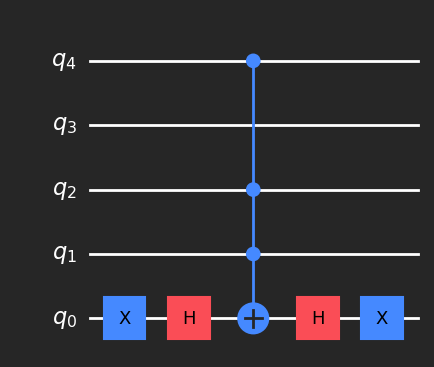

<IPython.core.display.Latex object>

In [5]:
oracle_circ = oracle(n_qbs, ignore_qb)
display(oracle_circ.draw(reverse_bits=True))

Utot = Operator(oracle_circ).data
Uctrl = Utot[::2, ::2][:(2**n_qbs)//2, :(2**n_qbs)//2]
array_to_latex(Uctrl, precision=3, max_size=1000)

we can see two marked elements, this because we have 3 qubits connected. we get a phase conversion when the non-connected qubit is both 0 or 1. Both $\ket{1011}$ (state 11 - 5th from the right) and $\ket{1111}$ (state 16 - 1st from the right), since q3 is not connected

In the original Groover algo we have all of them connected, so we get only one marked element (-1) 

To fix this phase we just need to invert it again with a multi-controlled Z gate.

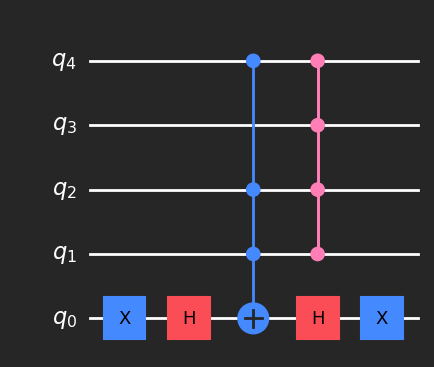

<IPython.core.display.Latex object>

In [6]:
def oracle(n, ignore_qb):
    ctrl_list = list(range(1, n))
    ctrl_list.remove(ignore_qb)
    mcz = ZGate().control(n-2)

    qc = QuantumCircuit(n)

    qc.x(0)
    qc.h(0)
    qc.mcx(ctrl_list, 0)
    qc.append(mcz, range(1, n))
    qc.h(0)
    qc.x(0)

    return qc

oracle_circ = oracle(n_qbs, ignore_qb)
display(oracle_circ.draw(reverse_bits=True))

Utot = Operator(oracle_circ).data
Uctrl = Utot[::2, ::2][:(2**n_qbs)//2, :(2**n_qbs)//2]
array_to_latex(Uctrl, precision=3, max_size=1000)

We get only one marked element. we get a phase shift of -1 only for $\ket{1011}$, since with $\ket{1111}$ the multi-controlled Z is activated and change the phase back.

now to identify the lazy employee, we just need to apply X gates before and after

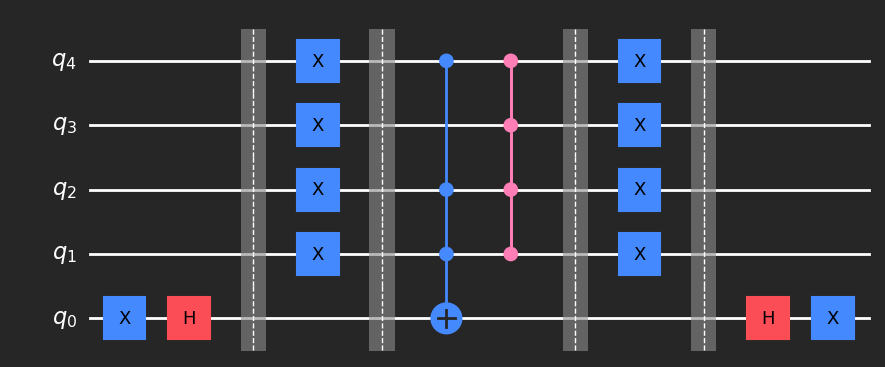

<IPython.core.display.Latex object>

In [7]:
def oracle(n, ignore_qb):
    ctrl_list = list(range(1, n))
    ctrl_list.remove(ignore_qb)
    mcz = ZGate().control(n-2)

    qc = QuantumCircuit(n)

    qc.x(0)
    qc.h(0)
    qc.barrier()
    for i in range(1, n):
        qc.x(i)
    qc.barrier()
    qc.mcx(ctrl_list, 0)
    qc.append(mcz, range(1, n))
    qc.barrier()
    for i in range(1, n):
        qc.x(i)
    qc.barrier()
    qc.h(0)
    qc.x(0)

    return qc

oracle_circ = oracle(n_qbs, ignore_qb)
display(oracle_circ.draw(reverse_bits=True))

Utot = Operator(oracle_circ).data
Uctrl = Utot[::2, ::2][:(2**n_qbs)//2, :(2**n_qbs)//2]
array_to_latex(Uctrl, precision=3, max_size=1000)

Now we have the -1 on the lazy employee. In this case is $\ket{0100}$ (q3 is the lazy employee) which is state 5

# Actual Grover's algo

Now we just need to put this oracle in the Groover's algo. regular groover use many shots and apply the oracle many times... this will be soled later.

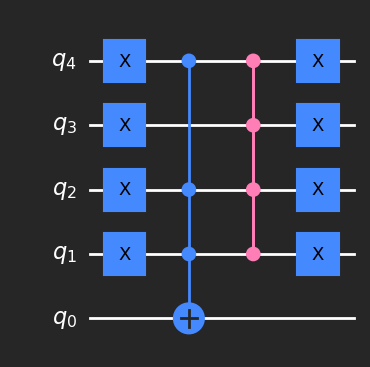

In [8]:
def oracle(n, ignore_qb):
    ctrl_list = list(range(1, n))
    ctrl_list.remove(ignore_qb)
    mcz = ZGate().control(n-2)

    qc = QuantumCircuit(n, name='Uf (oracle)')
    qc.x(range(1, n))
    qc.mcx(ctrl_list, 0)
    qc.append(mcz, range(1, n))
    qc.x(range(1, n))
    return qc

oracle_circ = oracle(n_qbs, ignore_qb)
display(oracle_circ.draw(reverse_bits=True))

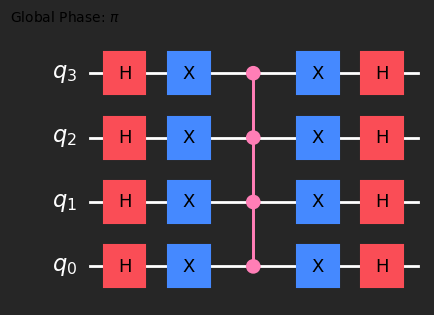

<IPython.core.display.Latex object>

In [9]:
def h_diffuser(n):
    mcz = ZGate().control(n-1)

    qc = QuantumCircuit(n, name='V (H-diffuser)', global_phase=np.pi)
    qc.h(range(n))
    qc.x(range(n))
    qc.append(mcz, range(n))
    qc.x(range(n))
    qc.h(range(n))
    return qc

n_qbs = 4
display(h_diffuser(n_qbs).draw(reverse_bits=True))
array_to_latex(Operator(h_diffuser(n_qbs)).data, precision=3, max_size=1000)

In [10]:
# num control qubits + ancillary
n_qbs = 5

# num iterations
rounds = np.round(np.pi/(4*np.arcsin(np.sqrt(1/(2**n_qbs - 1))))- 1/2, 4)
rounds_int = int(rounds)
print(f'Number of iterations (exact, integer): {rounds_int}, {rounds}')

# qubit to ignore
# ignore_qb = np.random.randint(1, n_qbs)
ignore_qb = 3 
print(f'Disconnected qubit: {ignore_qb}')

# expected output
output = [0]*n_qbs
output[ignore_qb] = 1
output = output[::-1] # reverse order
output.pop() # remove cickback qubit
print(f'Expected output: {output}')

Number of iterations (exact, integer): 3, 3.8492
Disconnected qubit: 3
Expected output: [0, 1, 0, 0]


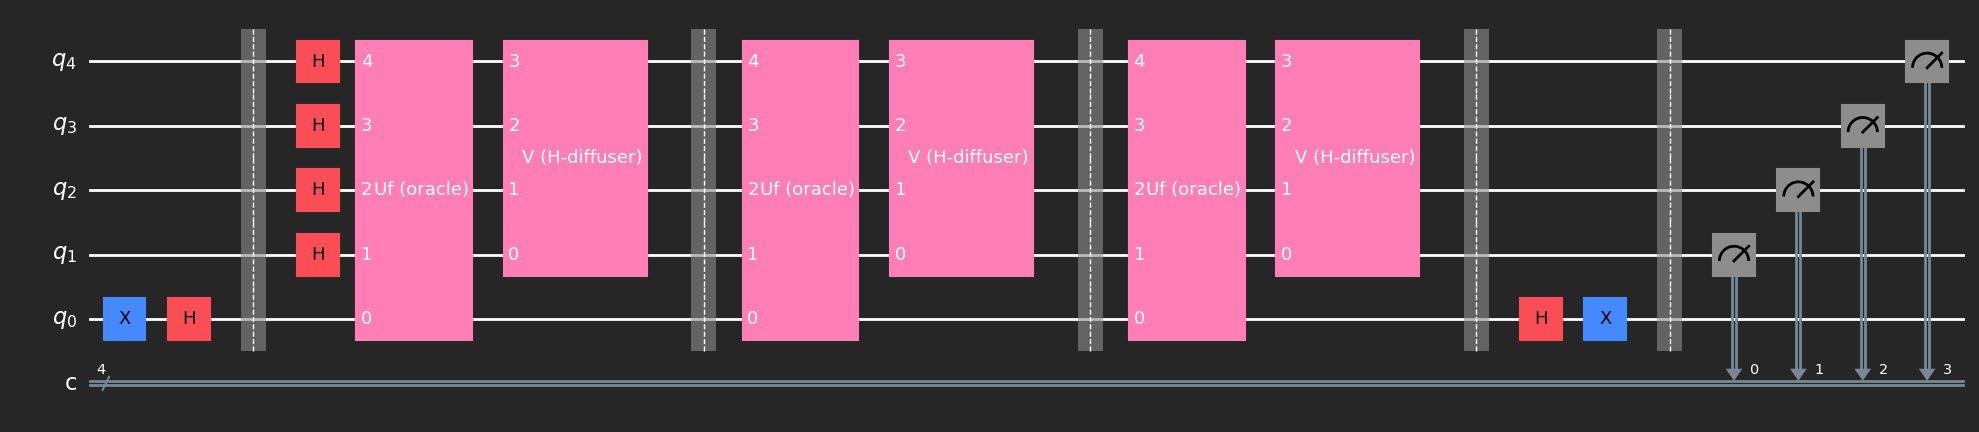

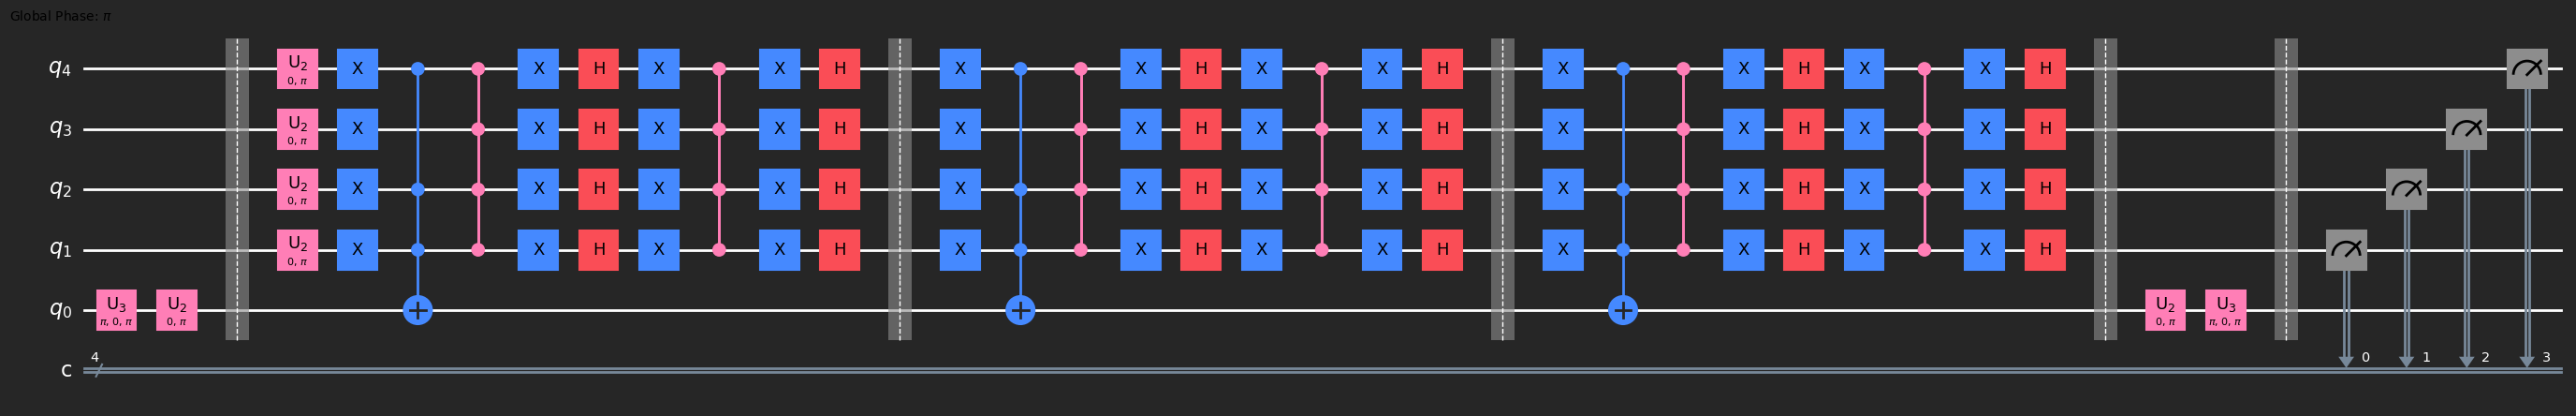

In [11]:
qc = QuantumCircuit(n_qbs, n_qbs-1)

# prepare | - > on ancillary qubit
qc.x(0)
qc.h(0)
qc.barrier()
qc.h(range(1, n_qbs))

for i in range(rounds_int):
    qc.append(oracle(n_qbs, ignore_qb), range(n_qbs))
    qc.append(h_diffuser(n_qbs-1), range(1, n_qbs))
    qc.barrier()

# revert | - > on ancillary qubit
qc.h(0)
qc.x(0)
qc.barrier()

qc.measure(range(1, n_qbs), range(n_qbs-1))
display(qc.draw(reverse_bits=True, fold=50))
display(qc.decompose().draw(reverse_bits=True, fold=50))


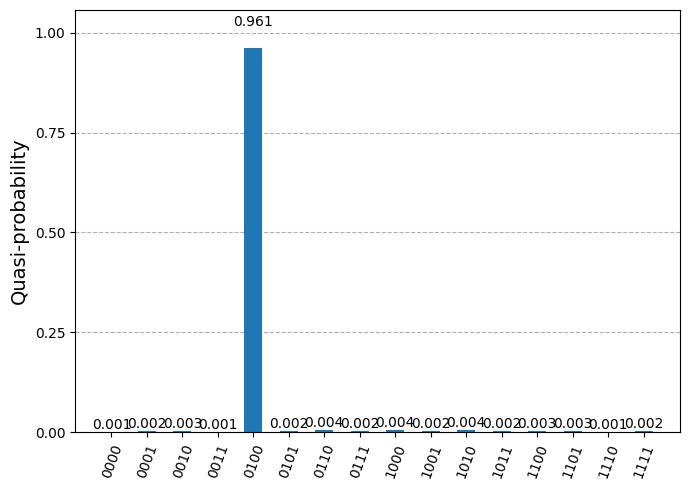

In [12]:
sim = Aer.get_backend('qasm_simulator')
qc_tr = transpile([qc], backend=sim, optimization_level=0)
job = sim.run(qc_tr, shots=2**11)
results = job.result()
counts = results.get_counts()
plot_distribution(counts)

We converge to the correct result. but the Groover's algo use many shots and many repetitions of the oracle.

# W state

AMPLITUDE AMPLIFICATION. the name of this different version of Grover, with a different state preparation and diffuser

In [28]:
def w_circ(n):
    prob_amp = np.sqrt(1/n)
    rot_ang = 2*np.arccos(prob_amp)

    qc_w = QuantumCircuit(n, name='W')
    qc_w.x(n-1)
    for i in range(n-2, -1, -1):
        comp_amp = np.sqrt((i + 2)/n)
        rot_ang = 2*np.arccos(prob_amp/comp_amp)
        qc_w.cry(rot_ang, i+1, i)
        qc_w.cx(i, i+1)

    return qc_w

<IPython.core.display.Latex object>

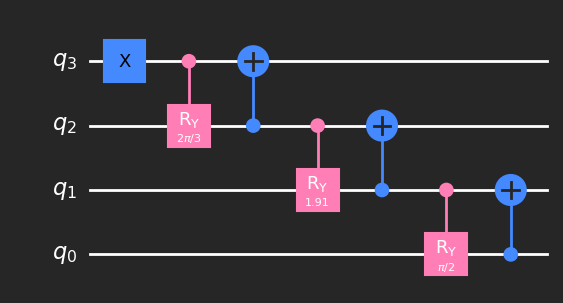

In [29]:
qc = w_circ(4)
display(Statevector(qc))
display(qc.draw(reverse_bits=True))

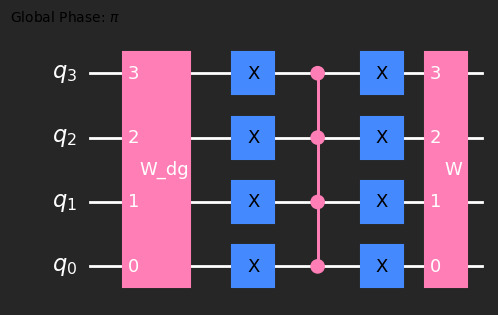

<IPython.core.display.Latex object>

In [38]:
def w_diffuser(n):
    mcz = ZGate().control(n-1)

    qc = QuantumCircuit(n, name='V (W-diffuser)', global_phase=np.pi)
    qc.append(w_circ(n).inverse(), range(n))
    qc.x(range(n))
    qc.append(mcz, range(n))
    qc.x(range(n))
    qc.append(w_circ(n), range(n))
    return qc

n_qubs = 4
diff = w_diffuser(n_qubs)
display(diff.draw(reverse_bits=True, fold=50))
array_to_latex(Operator(diff), max_size=2**n_qbs)

we can see the 1/2 in the rows/columns that are related to the power of two states $\ket{0001}$, $\ket{0010}$, $\ket{0100}$, $\ket{1000}$ 

Now we just need to use this in the algorithm.

And we need also to modify the oracle, we don't need anymore the CCCZ gate. because we have reduced the input state (we initialize it to $\ket{w}$ instead of $\ket{s}$).

In [31]:
# same as before, but without the mcz
def oracle(n, ignore_qb):
    ctrl_list = list(range(1, n))
    ctrl_list.remove(ignore_qb)
    # mcz = ZGate().control(n-2)

    qc = QuantumCircuit(n, name='Uf (oracle)')
    qc.x(range(1, n))
    qc.mcx(ctrl_list, 0)
    # qc.append(mcz, range(1, n))
    qc.x(range(1, n))
    return qc

In [32]:
# num control qubits + ancillary
n_qbs = 5

# num iterations
# BEFORE
# rounds = np.round(np.pi/(4*np.arcsin(np.sqrt(1/(2**n_qbs - 1))))- 1/2, 4)
# AFTER
# from (2**n_qbs - 1) to (n_qbs - 1) - we reduced the search space
rounds = np.round(np.pi/(4*np.arcsin(np.sqrt(1/(n_qbs - 1))))- 1/2, 4)
rounds_int = int(rounds)
print(f'Number of iterations (exact, integer): {rounds_int}, {rounds}')

# qubit to ignore
# ignore_qb = np.random.randint(1, n_qbs)
ignore_qb = 3 
print(f'Disconnected qubit: {ignore_qb}')

# expected output
output = [0]*n_qbs
output[ignore_qb] = 1
output = output[::-1] # reverse order
output.pop() # remove cickback qubit
print(f'Expected output: {output}')

Number of iterations (exact, integer): 1, 1.0
Disconnected qubit: 3
Expected output: [0, 1, 0, 0]


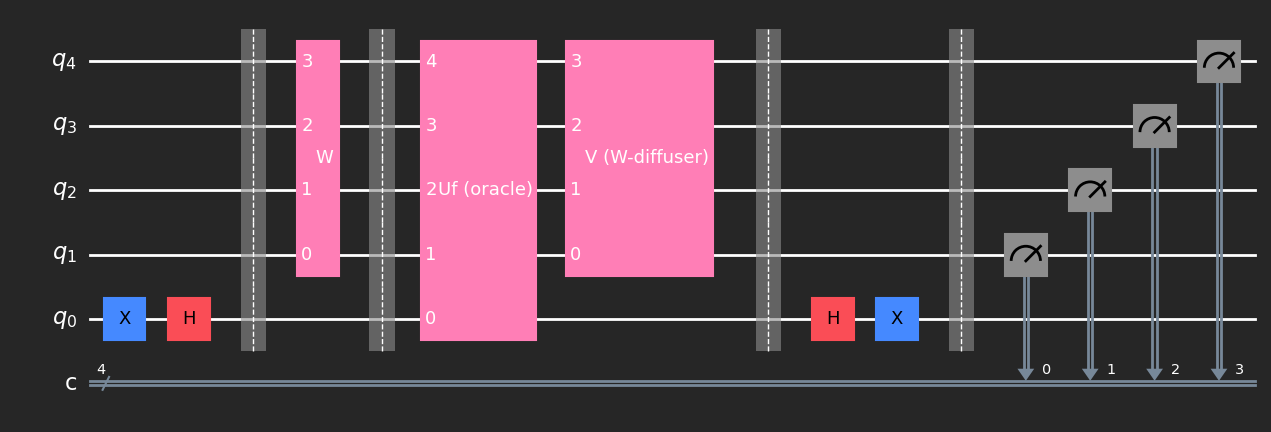

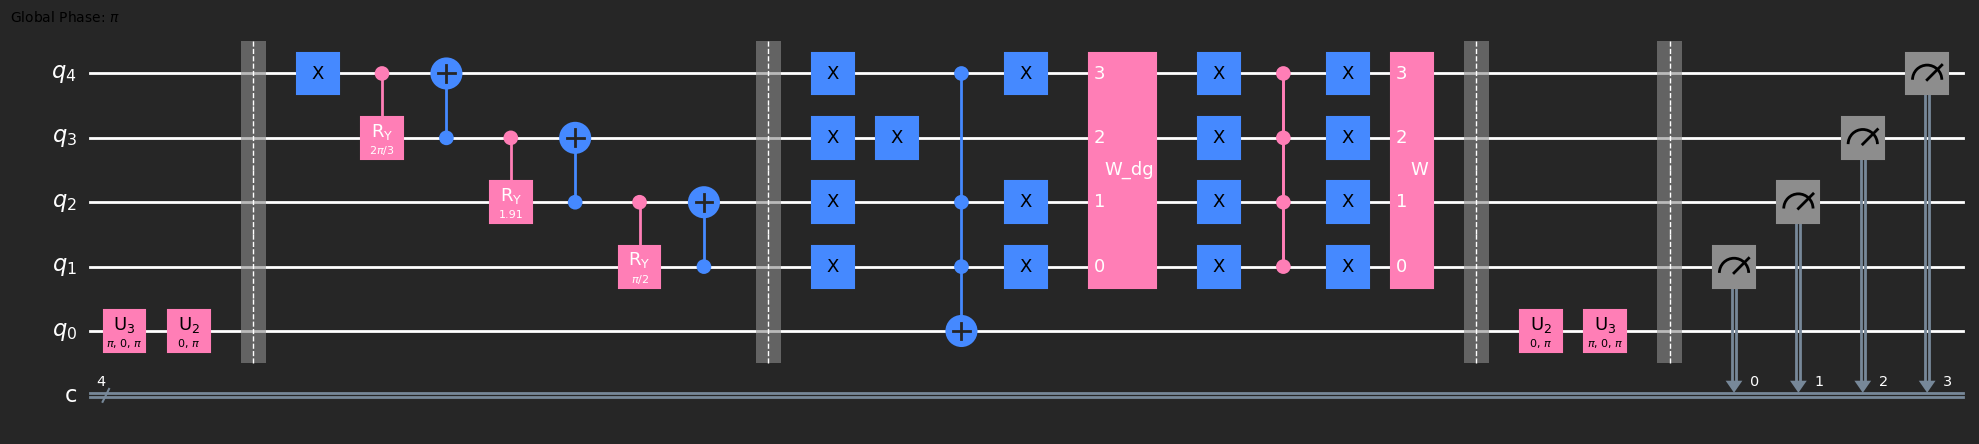

In [35]:
qc = QuantumCircuit(n_qbs, n_qbs-1)

# prepare | - > on ancillary qubit
qc.x(0)
qc.h(0)
qc.barrier()
qc.append(w_circ(n_qbs-1), range(1, n_qbs)) # W instead of H
qc.barrier()

for i in range(rounds_int):
    qc.append(oracle(n_qbs, ignore_qb), range(n_qbs))
    qc.append(w_diffuser(n_qbs-1), range(1, n_qbs)) # w_diffuser instead of h_diffuser
    qc.barrier()

# revert | - > on ancillary qubit
qc.h(0)
qc.x(0)
qc.barrier()

qc.measure(range(1, n_qbs), range(n_qbs-1))
display(qc.draw(reverse_bits=True, fold=50))
display(qc.decompose().draw(reverse_bits=True, fold=50))


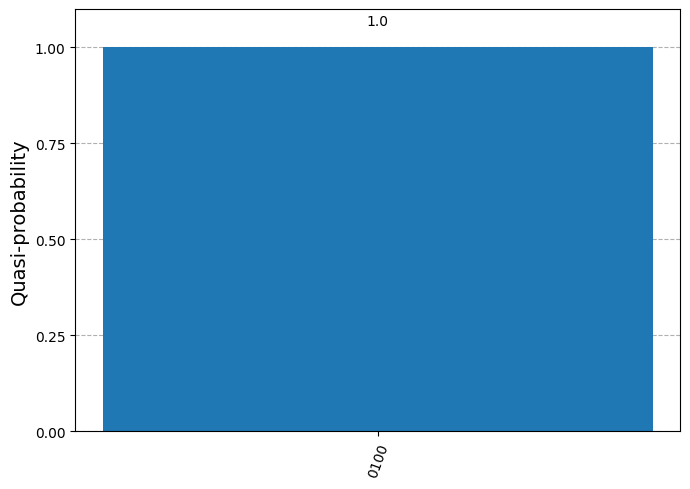

In [36]:
sim = Aer.get_backend('qasm_simulator')
qc_tr = transpile([qc], backend=sim, optimization_level=0)
job = sim.run(qc_tr, shots=2**11)
results = job.result()
counts = results.get_counts()
plot_distribution(counts)

with Prob of 1 we get the correct state (we have doing many shots but is just for checking it)